In [1]:
using GLM
using StatsBase
using DataFrames
using Dagitty
using Turing
using StatsPlots
using StatisticalRethinking
using Logging

default(labels=false)
Logging.disable_logging(Logging.Warn);

Code 6.1

In [2]:
Random.seed!(1917)
N = 200   # grant proposals
p = 0.1   # proportion to select

# uncorrelated newsworthiness and trustworthiness
nw = rand(Normal(), N)
tw = rand(Normal(), N)

# select top 10% of combined score
s = nw .+ tw
q = quantile(s, 1-p)
selected = s .>= q
cor(tw[selected], nw[selected])

-0.785212889969301

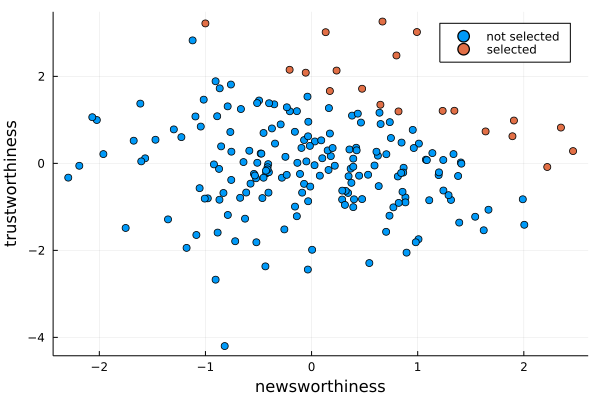

In [3]:
scatter(nw[.!selected], tw[.!selected]; xlab="newsworthiness", ylab="trustworthiness", label="not selected")
scatter!(nw[selected], tw[selected]; label="selected")

# 6.1 Multicollinearity

Code 6.2

In [4]:
Random.seed!(100)
N = 100
height = rand(Normal(10, 2), N)
leg_prop = rand(Uniform(0.4, 0.5), N)
leg_left = leg_prop .* height .+ rand(Normal(0, 0.02), N)
leg_right = leg_prop .* height .+ rand(Normal(0, 0.02), N)
d = DataFrame(:height => height, :leg_left => leg_left, :leg_right => leg_right);

Code 6.3

In [5]:
@model function model_m6_1(leg_left, leg_right, height)
    a ~ Normal(10, 100)
    bl ~ Normal(2, 10)
    br ~ Normal(2, 10)
    μ = @. a + bl * leg_left + br * leg_right
    σ ~ Exponential(1)
    height ~ MvNormal(μ, σ)
end

m6_1 = sample(model_m6_1(d.leg_left, d.leg_right, d.height), NUTS(), 1000)
m6_1_df = DataFrame(m6_1)
precis(m6_1_df)

┌───────┬────────────────────────────────────────────────────────┐
│ param │   mean     std     5.5%     50%   94.5%      histogram │
├───────┼────────────────────────────────────────────────────────┤
│     a │ 0.6338  0.3296    0.091  0.6329  1.1752   ▁▁▁▃▅██▆▃▂▁▁ │
│    bl │ 1.7655    1.96  -1.4323  1.8123  4.8364  ▁▁▂▂▅▇██▅▄▂▁▁ │
│    br │ 0.3122  1.9688   -2.772  0.2748  3.4925  ▁▁▂▄▅██▇▅▃▂▁▁ │
│     σ │ 0.6126  0.0449   0.5446  0.6099  0.6885         ▂▇█▃▁▁ │
└───────┴────────────────────────────────────────────────────────┘


Code 6.4

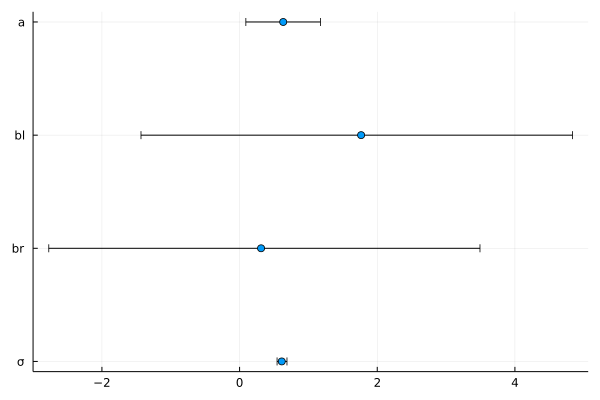

In [6]:
coeftab_plot(m6_1_df)

Code 6.5

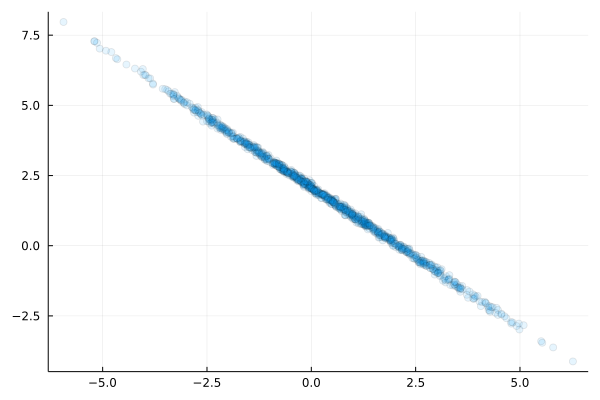

In [7]:
scatter(m6_1_df.br, m6_1_df.bl; alpha=0.1)

Code 6.6

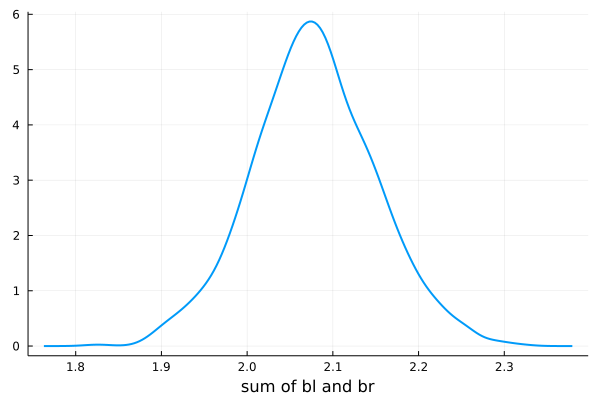

In [8]:
@df m6_1_df density(:br + :bl; lw=2, xlab="sum of bl and br")

Code 6.7

In [9]:
@model function model_m6_2(leg_left, height)
    a ~ Normal(10, 100)
    bl ~ Normal(2, 10)
    μ = @. a + bl * leg_left
    σ ~ Exponential(1)
    height ~ MvNormal(μ, σ)
end

m6_2 = sample(model_m6_2(d.leg_left, d.height), NUTS(), 1000)
m6_2_df = DataFrame(m6_2)
precis(m6_2_df)

┌───────┬────────────────────────────────────────────────────────┐
│ param │   mean     std    5.5%     50%   94.5%       histogram │
├───────┼────────────────────────────────────────────────────────┤
│     a │ 0.6728   0.327  0.1407  0.6611  1.1928    ▁▁▁▂▅▇█▇▄▂▁▁ │
│    bl │ 2.0684  0.0712   1.956  2.0689  2.1783      ▁▁▂▄▇█▆▃▁▁ │
│     σ │ 0.6063  0.0414  0.5434  0.6051  0.6753  ▁▁▂▄▇██▆▄▃▂▁▁▁ │
└───────┴────────────────────────────────────────────────────────┘


In [10]:
std(m6_1_df.bl), std(m6_1_df.br), std(m6_1_df.bl + m6_1_df.br)

(1.9600064957206784, 1.9687730215545687, 0.07174624055531233)

Code 6.8

In [11]:
d = DataFrame(CSV.File("data/milk.csv",  missingstring="NA"))

# get rid of dots in column names
rename!(n -> replace(n, "." => "_"), d)

d[!,:K] = standardize(ZScoreTransform, d.kcal_per_g)
d[!,:F] = standardize(ZScoreTransform, d.perc_fat)
d[!,:L] = standardize(ZScoreTransform, d.perc_lactose);

Code 6.9

In [12]:
@model function model_m6_3(F, K)
    a ~ Normal(0, 0.2)
    bF ~ Normal(0, 0.5)
    μ = @. a + F * bF
    σ ~ Exponential(1)
    K ~ MvNormal(μ, σ)
end

m6_3 = sample(model_m6_3(d.F, d.K), NUTS(), 1000)
m6_3_df = DataFrame(m6_3)

@model function model_m6_4(L, K)
    a ~ Normal(0, 0.2)
    bL ~ Normal(0, 0.5)
    μ = @. a + L * bL
    σ ~ Exponential(1)
    K ~ MvNormal(μ, σ)
end

m6_4 = sample(model_m6_4(d.L, d.K), NUTS(), 1000)
m6_4_df = DataFrame(m6_4)

precis(m6_3_df)
precis(m6_4_df)

┌───────┬─────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%     50%   94.5%      histogram │
├───────┼─────────────────────────────────────────────────────────┤
│     a │ -0.0019  0.0858  -0.1392  -0.002  0.1269  ▁▁▁▃▅██▆▃▁▁▁▁ │
│    bF │  0.8528  0.0898    0.695  0.8562  0.9923   ▁▁▂▃▆██▇▃▂▁▁ │
│     σ │  0.4901  0.0666    0.396  0.4851  0.6026    ▁▂▇█▆▄▂▁▁▁▁ │
└───────┴─────────────────────────────────────────────────────────┘
┌───────┬──────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%     histogram │
├───────┼──────────────────────────────────────────────────────────┤
│     a │ -0.0009  0.0733  -0.1186   0.0022   0.1182  ▁▁▁▂▅██▅▂▁▁▁ │
│    bL │ -0.8944  0.0762  -1.0148  -0.8951  -0.7735      ▁▂██▂▁▁▁ │
│     σ │  0.4124  0.0597    0.328   0.4058   0.5152    ▁▄██▄▂▁▁▁▁ │
└───────┴──────────────────────────────────────────────────────────┘


Code 6.10

In [13]:
@model function model_m6_5(F, L, K)
    a ~ Normal(0, 0.2)
    bF ~ Normal(0, 0.5)
    bL ~ Normal(0, 0.5)
    μ = @. a + F * bF + L * bL
    σ ~ Exponential(1)
    K ~ MvNormal(μ, σ)
end

m6_5 = sample(model_m6_5(d.F, d.L, d.K), NUTS(), 1000)
m6_5_df = DataFrame(m6_5)
precis(m6_5_df)

┌───────┬───────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%   94.5%       histogram │
├───────┼───────────────────────────────────────────────────────────┤
│     a │ -0.0002  0.0749  -0.1122   -0.001  0.1187   ▁▁▁▁▃▆██▅▃▁▁▁ │
│    bF │   0.268  0.2011  -0.0516   0.2635  0.5871        ▁▁▂▆█▅▁▁ │
│    bL │ -0.6537   0.196  -0.9458  -0.6601  -0.321  ▁▁▁▁▃▅██▇▅▃▂▁▁ │
│     σ │  0.4153  0.0604    0.333   0.4078  0.5214      ▁▃██▄▂▁▁▁▁ │
└───────┴───────────────────────────────────────────────────────────┘


Code 6.11

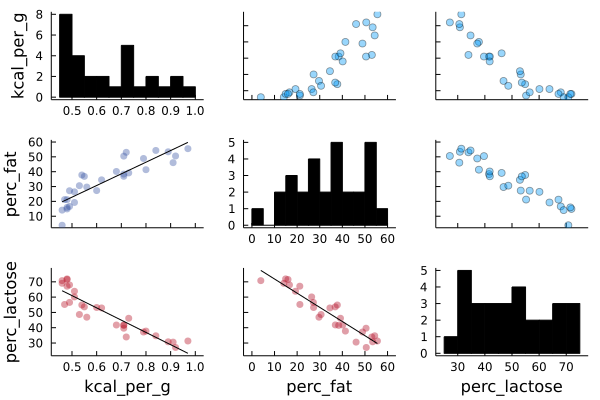

In [14]:
@df d corrplot([:kcal_per_g :perc_fat :perc_lactose]; seriestype=:scatter, bins=10, grid=false)

Code 6.12

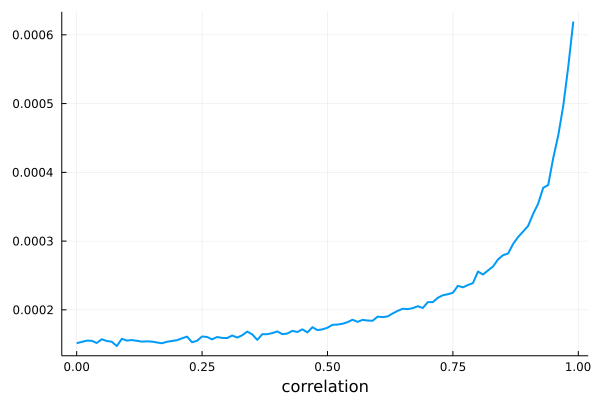

In [25]:
# get mean stderr for linear model's scale
function stderr_for_r(r)
    σ = sqrt(1-r^2)*var(d.perc_fat)
    fat_scaled = r .* d.perc_fat
    stderr_x = [
        begin
            x = d.perc_fat .+ rand(MvNormal(fat_scaled, σ))
            m = lm(hcat(ones(length(x)), x), d.kcal_per_g)
            stderror(m)[2]
        end
        for _ in 1:100
    ]
    s = mean(stderr_x)
end

r_seq = range(0, 0.99; step=0.01)
s = stderr_for_r.(r_seq)
plot(r_seq, s; lw=2, xlab="correlation")

## 6.2 Post-treatment bias